In [1]:
from ema_workbench import save_results, ema_logging
from ema_workbench.util.utilities import load_results
import numpy as np
import pandas as pd
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, SequentialEvaluator, ema_logging)
from problem_formulation import get_model_for_problem_formulation

from ema_workbench.analysis import parcoords, prim

dike_model, planning_steps = get_model_for_problem_formulation(6)

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Ran in dike_model_optimization
results = pd.read_csv("opt_results_10000_nfe.csv", index_col=0)
convergence = pd.read_csv("opt_convergence_10000nfe.csv", index_col=0)

In [5]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,1,1,0,0,1,0,1,0,1,0,...,1.244627e+08,0.000000,0.000000e+00,2.669677e+07,0.000000,0.000000e+00,1.913185e+08,0.000000,1.081800e+09,63.677361
1,0,1,1,1,1,0,1,1,0,0,...,1.050734e+08,0.000000,0.000000e+00,3.185173e+07,0.000000,0.000000e+00,1.185384e+08,0.000000,1.299600e+09,0.000000
2,1,0,0,0,1,1,0,1,0,0,...,5.742314e+07,0.000000,0.000000e+00,3.464204e+07,0.000000,0.000000e+00,2.058960e+08,0.000000,1.319200e+09,0.000000
3,1,0,1,1,1,0,1,1,0,1,...,1.028117e+08,0.000000,0.000000e+00,2.416243e+07,0.000000,0.000000e+00,8.895480e+07,0.000000,1.164700e+09,0.000000
4,0,0,1,0,0,0,1,1,0,0,...,5.742314e+07,0.000000,0.000000e+00,4.529582e+07,0.000000,1.142561e+07,8.125036e+07,0.001534,9.143000e+08,2145.312038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,0,0,0,0,0,0,0,0,0,1,...,5.569023e+07,0.005825,0.000000e+00,7.217324e+07,0.000000,0.000000e+00,1.177570e+08,0.000000,3.773000e+08,2324.707170
2521,1,1,0,0,1,0,1,0,1,0,...,9.531741e+07,0.000000,1.487202e+05,3.160334e+07,0.000095,3.889310e+07,2.503721e+07,0.043132,8.257000e+08,0.000000
2522,0,1,0,0,0,0,0,0,0,0,...,5.008175e+07,0.050744,1.038739e+07,1.426165e+07,0.006342,9.531683e+07,0.000000e+00,0.105790,8.460000e+07,0.000000
2523,0,0,0,0,0,0,0,1,0,0,...,4.129222e+07,0.043076,1.751111e+06,1.936463e+07,0.001046,1.235812e+08,0.000000e+00,0.137501,5.429000e+08,0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

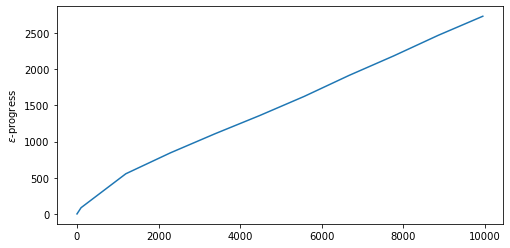

In [5]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
plt.show

# Not converged

will continue to get program running

In [6]:
results.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expecte

In [7]:
data = results.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]
data

,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,1.244627e+08,0.000000,1.081800e+09,63.677361
1,0.000000e+00,1.050734e+08,0.000000,1.299600e+09,0.000000
2,0.000000e+00,5.742314e+07,0.000000,1.319200e+09,0.000000
3,0.000000e+00,1.028117e+08,0.000000,1.164700e+09,0.000000
4,0.000000e+00,5.742314e+07,0.000000,9.143000e+08,2145.312038
...,...,...,...,...,...
2520,2.210973e+07,5.569023e+07,0.005825,3.773000e+08,2324.707170
2521,0.000000e+00,9.531741e+07,0.000000,8.257000e+08,0.000000
2522,2.283561e+07,5.008175e+07,0.050744,8.460000e+07,0.000000
2523,1.965359e+07,4.129222e+07,0.043076,5.429000e+08,0.000000


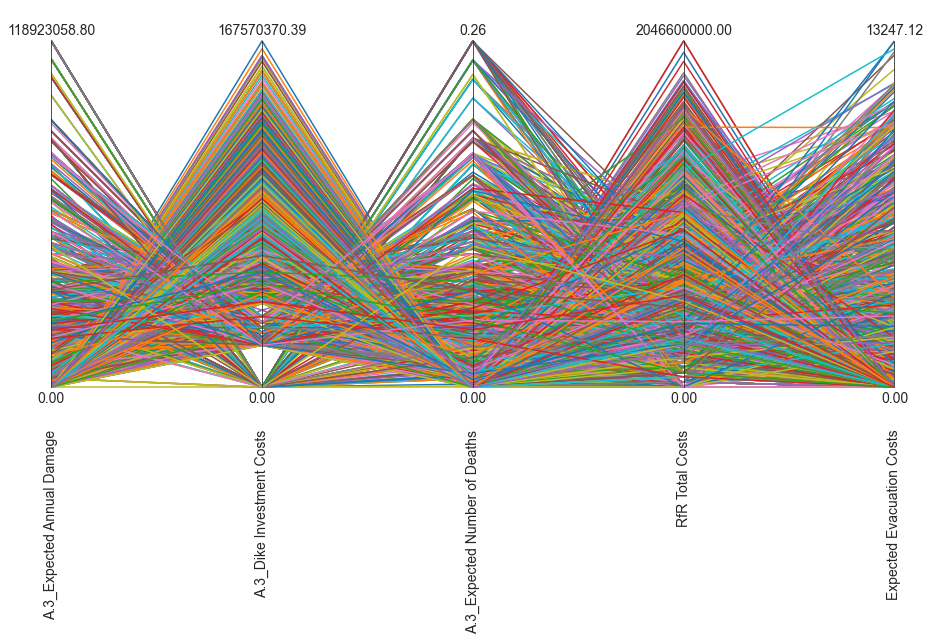

In [9]:
data = results.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]

limits = parcoords.get_limits(data)
limits.loc[0, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
fig = paraxes.fig
fig.set_size_inches(15,30)
plt.show()

In [10]:
thresholds = results[(results['A.1_Expected Number of Deaths'] < 0.01) & (results['A.2_Expected Number of Deaths'] < 0.01) & (results['A.3_Expected Number of Deaths'] < 0.01) &
                     (results['A.4_Expected Number of Deaths'] < 0.01) & (results['A.5_Expected Number of Deaths'] < 0.01) & (results['A.3_Dike Investment Costs'] < 1e8) & 
                     (results["RfR Total Costs"] < 1e8)
                 
                 ]
# thresholds[['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
#                        'RfR Total Costs', 'Expected Evacuation Costs']]

thresholds.loc[:, [o.name for o in dike_model.outcomes]]

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
483,6.468190e+07,7.709999e+07,0.006605,0.000000e+00,1.744507e+08,0.000000,8.515366e+06,4.760489e+07,0.002248,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,1478.169519
485,7.202683e+06,1.242311e+08,0.000758,6.354914e+06,1.245739e+08,0.000878,0.000000e+00,9.952792e+07,0.000000,1.043617e+07,6.320800e+06,0.000800,2.628576e+07,7.532974e+07,0.003486,61400000.0,3487.034111
838,0.000000e+00,7.643154e+07,0.000000,6.842075e+06,9.398663e+07,0.000980,1.842266e+07,4.387810e+07,0.004937,5.398397e+06,3.018556e+07,0.000399,6.828624e+07,3.667668e+07,0.009090,84600000.0,7180.650680
902,7.202683e+06,1.826044e+08,0.000758,2.020816e+06,1.815215e+08,0.000288,1.808643e+07,4.129222e+07,0.004777,7.690926e+06,6.320800e+06,0.000607,5.789414e+07,5.642588e+07,0.007741,30700000.0,6353.025531
904,6.468190e+07,1.760122e+08,0.006605,0.000000e+00,2.315268e+08,0.000000,0.000000e+00,3.728504e+07,0.000000,1.313260e+07,0.000000e+00,0.000969,3.680157e+06,8.954281e+07,0.000489,30700000.0,2437.149428
915,0.000000e+00,1.869912e+08,0.000000,0.000000e+00,2.043552e+08,0.000000,9.748882e+06,6.633023e+07,0.002614,5.398397e+06,3.018556e+07,0.000399,7.002511e+07,4.027367e+07,0.009341,0.0,6395.038092
1019,0.000000e+00,2.258663e+08,0.000000,4.171280e+07,4.784270e+07,0.005744,3.339671e+07,5.990344e+07,0.008664,4.639841e+06,6.320800e+06,0.000349,4.446715e+06,7.908444e+07,0.000586,0.0,5352.672726
1106,7.202683e+06,1.031623e+08,0.000758,0.000000e+00,1.338442e+08,0.000000,2.150205e+06,4.871687e+07,0.000581,2.584707e+06,2.106978e+07,0.000205,1.715732e+07,1.034994e+08,0.002307,0.0,1789.739950
1344,0.000000e+00,2.190127e+08,0.000000,3.421037e+06,8.861311e+07,0.004083,0.000000e+00,7.751737e+07,0.000000,1.089821e+07,1.258646e+07,0.006764,0.000000e+00,1.119528e+08,0.000000,0.0,0.000000
1374,0.000000e+00,2.663095e+08,0.000000,0.000000e+00,1.387250e+08,0.000000,2.498581e+07,5.277101e+07,0.006671,2.150894e+06,2.322669e+07,0.000170,0.000000e+00,1.086282e+08,0.000000,0.0,1509.902486


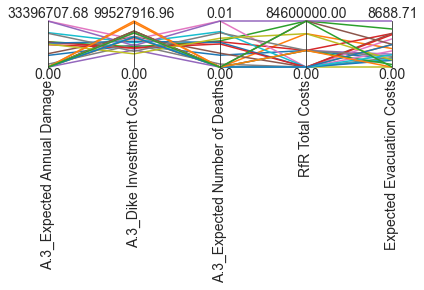

<Figure size 1440x720 with 0 Axes>

In [11]:
data = thresholds.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]

limits = parcoords.get_limits(data)
limits.loc[0, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.figure(figsize=(20, 10))
plt.show()

In [12]:
policies = thresholds.drop([o.name for o in dike_model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
483,0,0,0,0,0,0,1,0,0,0,...,2,0,1,4,7,6,7,5,5,6
485,0,0,0,0,0,0,1,0,1,0,...,3,6,1,7,0,1,0,0,4,5
838,0,0,1,0,0,0,0,0,0,0,...,3,2,0,1,0,7,6,0,0,5
902,0,0,0,0,0,0,0,0,1,0,...,5,1,0,1,1,0,0,0,1,3
904,0,0,0,0,0,0,0,0,1,0,...,7,8,0,0,0,0,0,0,6,6
915,0,0,0,0,0,0,0,0,0,0,...,4,2,1,1,0,7,6,0,0,6
1019,0,0,0,0,0,0,0,0,0,0,...,3,0,7,1,0,1,0,0,7,2
1106,0,0,0,0,0,0,0,0,0,0,...,3,3,0,2,1,7,0,1,7,1
1344,0,0,0,0,0,0,0,0,0,0,...,0,7,0,7,0,0,6,7,1,2
1374,0,0,0,0,0,0,0,0,0,0,...,0,1,0,6,1,1,4,7,1,1


In [13]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

## Re-evaluate candidate solutions under uncertainty

In [14]:
n_scenarios = 1000
try:
    results = load_results("1000scen_23_pol")
except IOError:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                policies_to_evaluate)
    save_results(results, "1000scen_23_pol")

[MainProcess/INFO] results loaded succesfully from C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\1000scen_23_pol


In [15]:
experiments, outcomes = results

In [16]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,18.0,260.815127,1.5,0.995705,192.169571,1.0,0.048047,199.997432,1.0,0.384613,...,4.0,7.0,6.0,7.0,5.0,5.0,6.0,1,483,dikesnet
1,29.0,96.323586,1.0,0.777606,178.084475,1.5,0.849570,151.278584,10.0,0.811919,...,4.0,7.0,6.0,7.0,5.0,5.0,6.0,2,483,dikesnet
2,20.0,35.387129,10.0,0.800615,211.244183,1.5,0.456357,267.955702,1.5,0.906415,...,4.0,7.0,6.0,7.0,5.0,5.0,6.0,3,483,dikesnet
3,79.0,83.434862,1.0,0.528284,98.717606,10.0,0.630985,287.878416,1.5,0.014994,...,4.0,7.0,6.0,7.0,5.0,5.0,6.0,4,483,dikesnet
4,38.0,312.219198,1.5,0.250484,327.662049,1.5,0.801860,114.185722,1.0,0.479886,...,4.0,7.0,6.0,7.0,5.0,5.0,6.0,5,483,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22995,6.0,219.061468,10.0,0.181362,264.020338,1.0,0.586264,81.747812,10.0,0.092039,...,6.0,1.0,0.0,0.0,3.0,7.0,6.0,996,2363,dikesnet
22996,58.0,56.532732,1.0,0.400841,243.528183,1.5,0.462469,215.071915,1.5,0.377047,...,6.0,1.0,0.0,0.0,3.0,7.0,6.0,997,2363,dikesnet
22997,103.0,200.716924,1.5,0.739988,220.190309,1.0,0.232676,131.306596,10.0,0.409594,...,6.0,1.0,0.0,0.0,3.0,7.0,6.0,998,2363,dikesnet
22998,51.0,271.496237,1.5,0.628068,214.487782,10.0,0.783356,175.123037,1.0,0.844692,...,6.0,1.0,0.0,0.0,3.0,7.0,6.0,999,2363,dikesnet


# Prim

In [17]:
experiments.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                     float64
0_RfR 1                     float64
0_RfR 2                     float64
1_RfR 0                     float64
1_RfR 1                     float64
1_RfR 2                     float64
2_RfR 0                     float64
2_RfR 1                     float64
2_RfR 2                     

# Search for scenarios where policies have failed

In [17]:
x = experiments.drop([o.name for o in dike_model.levers], axis=1)
y = (outcomes['A.3_Expected Number of Deaths'] > 0.01) & (outcomes['Expected Evacuation Costs'] > 500)



#& (outcomes['A.2_Expected Number of Deaths'] > 0.01) \
    #& (outcomes['A.3_Expected Number of Deaths'] > 0.01) & (outcomes['A.4_Expected Number of Deaths'] > 0.01) & (outcomes['A.5_Expected Number of Deaths'] > 0.01)

In [18]:
data = pd.DataFrame.from_dict(outcomes)[y]
data

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,7.709999e+07,0.000000,8.576938e+06,1.744507e+08,0.001223,4.029768e+07,4.760489e+07,0.011323,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,2917.597875
3,5.918871e+07,7.709999e+07,0.004862,0.000000e+00,1.744507e+08,0.000000,1.606429e+09,4.760489e+07,0.271040,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,71252.216845
8,4.317825e+08,7.709999e+07,0.042338,1.179013e+07,1.744507e+08,0.001802,2.915428e+08,4.760489e+07,0.075773,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,25654.508186
11,2.130222e+08,7.709999e+07,0.016976,0.000000e+00,1.744507e+08,0.000000,6.829652e+08,4.760489e+07,0.147409,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,40100.743491
12,0.000000e+00,7.709999e+07,0.000000,0.000000e+00,1.744507e+08,0.000000,9.246037e+07,4.760489e+07,0.022094,0.000000e+00,5.225898e+07,0.000000,0.000000e+00,1.364194e+08,0.000000,30700000.0,4748.846956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20553,1.003351e+09,1.805966e+08,0.076604,1.057325e+07,8.772265e+07,0.001207,5.143498e+07,6.483599e+07,0.012256,2.938921e+07,0.000000e+00,0.001966,0.000000e+00,1.001055e+08,0.000000,0.0,16462.068885
20594,0.000000e+00,1.805966e+08,0.000000,1.898746e+07,8.772265e+07,0.002411,1.273154e+08,6.483599e+07,0.025891,1.319064e+07,0.000000e+00,0.000754,1.517896e+07,1.001055e+08,0.001576,0.0,8359.083731
20596,0.000000e+00,1.805966e+08,0.000000,3.974167e+08,8.772265e+07,0.051676,2.613981e+08,6.483599e+07,0.064270,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.001055e+08,0.000000,0.0,43481.171486
20621,0.000000e+00,1.805966e+08,0.000000,0.000000e+00,8.772265e+07,0.000000,6.266533e+07,6.483599e+07,0.019089,1.103226e+07,0.000000e+00,0.000804,0.000000e+00,1.001055e+08,0.000000,0.0,4907.055729


In [20]:
x.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
scenario                   category
policy                     category
model                      category
dtype: object

In [21]:
x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y)

In [22]:
rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
rotated_x = rotated_x.drop(columns=['policy'])

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 23000 points remaining, containing 5220 cases of interest
[MainProcess/INFO] mean: 0.8130434782608695, mass: 0.01, coverage: 0.03582375478927203, density: 0.8130434782608695 restricted_dimensions: 10


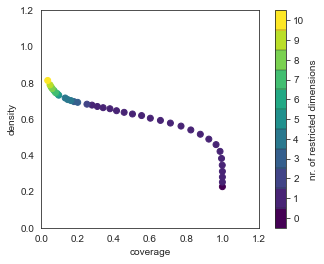

In [26]:
from ema_workbench.analysis.prim_util import PRIMObjectiveFunctions


prim_alg = prim.Prim(rotated_x, y, threshold=0.8, peel_alpha=0.1, mass_min=0.01)
box = prim_alg.find_box()

box.show_tradeoff()
plt.show()

In [27]:
box.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.226957,0,1.000,0.226957,0
1,1.000000,0.252174,1,0.900,0.252174,1
2,1.000000,0.280193,2,0.810,0.280193,1
3,1.000000,0.311326,3,0.729,0.311326,1
4,0.999234,0.345705,4,0.656,0.345705,1
5,0.995211,0.382830,5,0.590,0.382830,1
6,0.986973,0.421846,6,0.531,0.421846,1
7,0.964943,0.459119,7,0.477,0.459119,1
8,0.925096,0.489409,8,0.429,0.489409,1
9,0.878161,0.516333,9,0.386,0.516333,1


C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:404: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


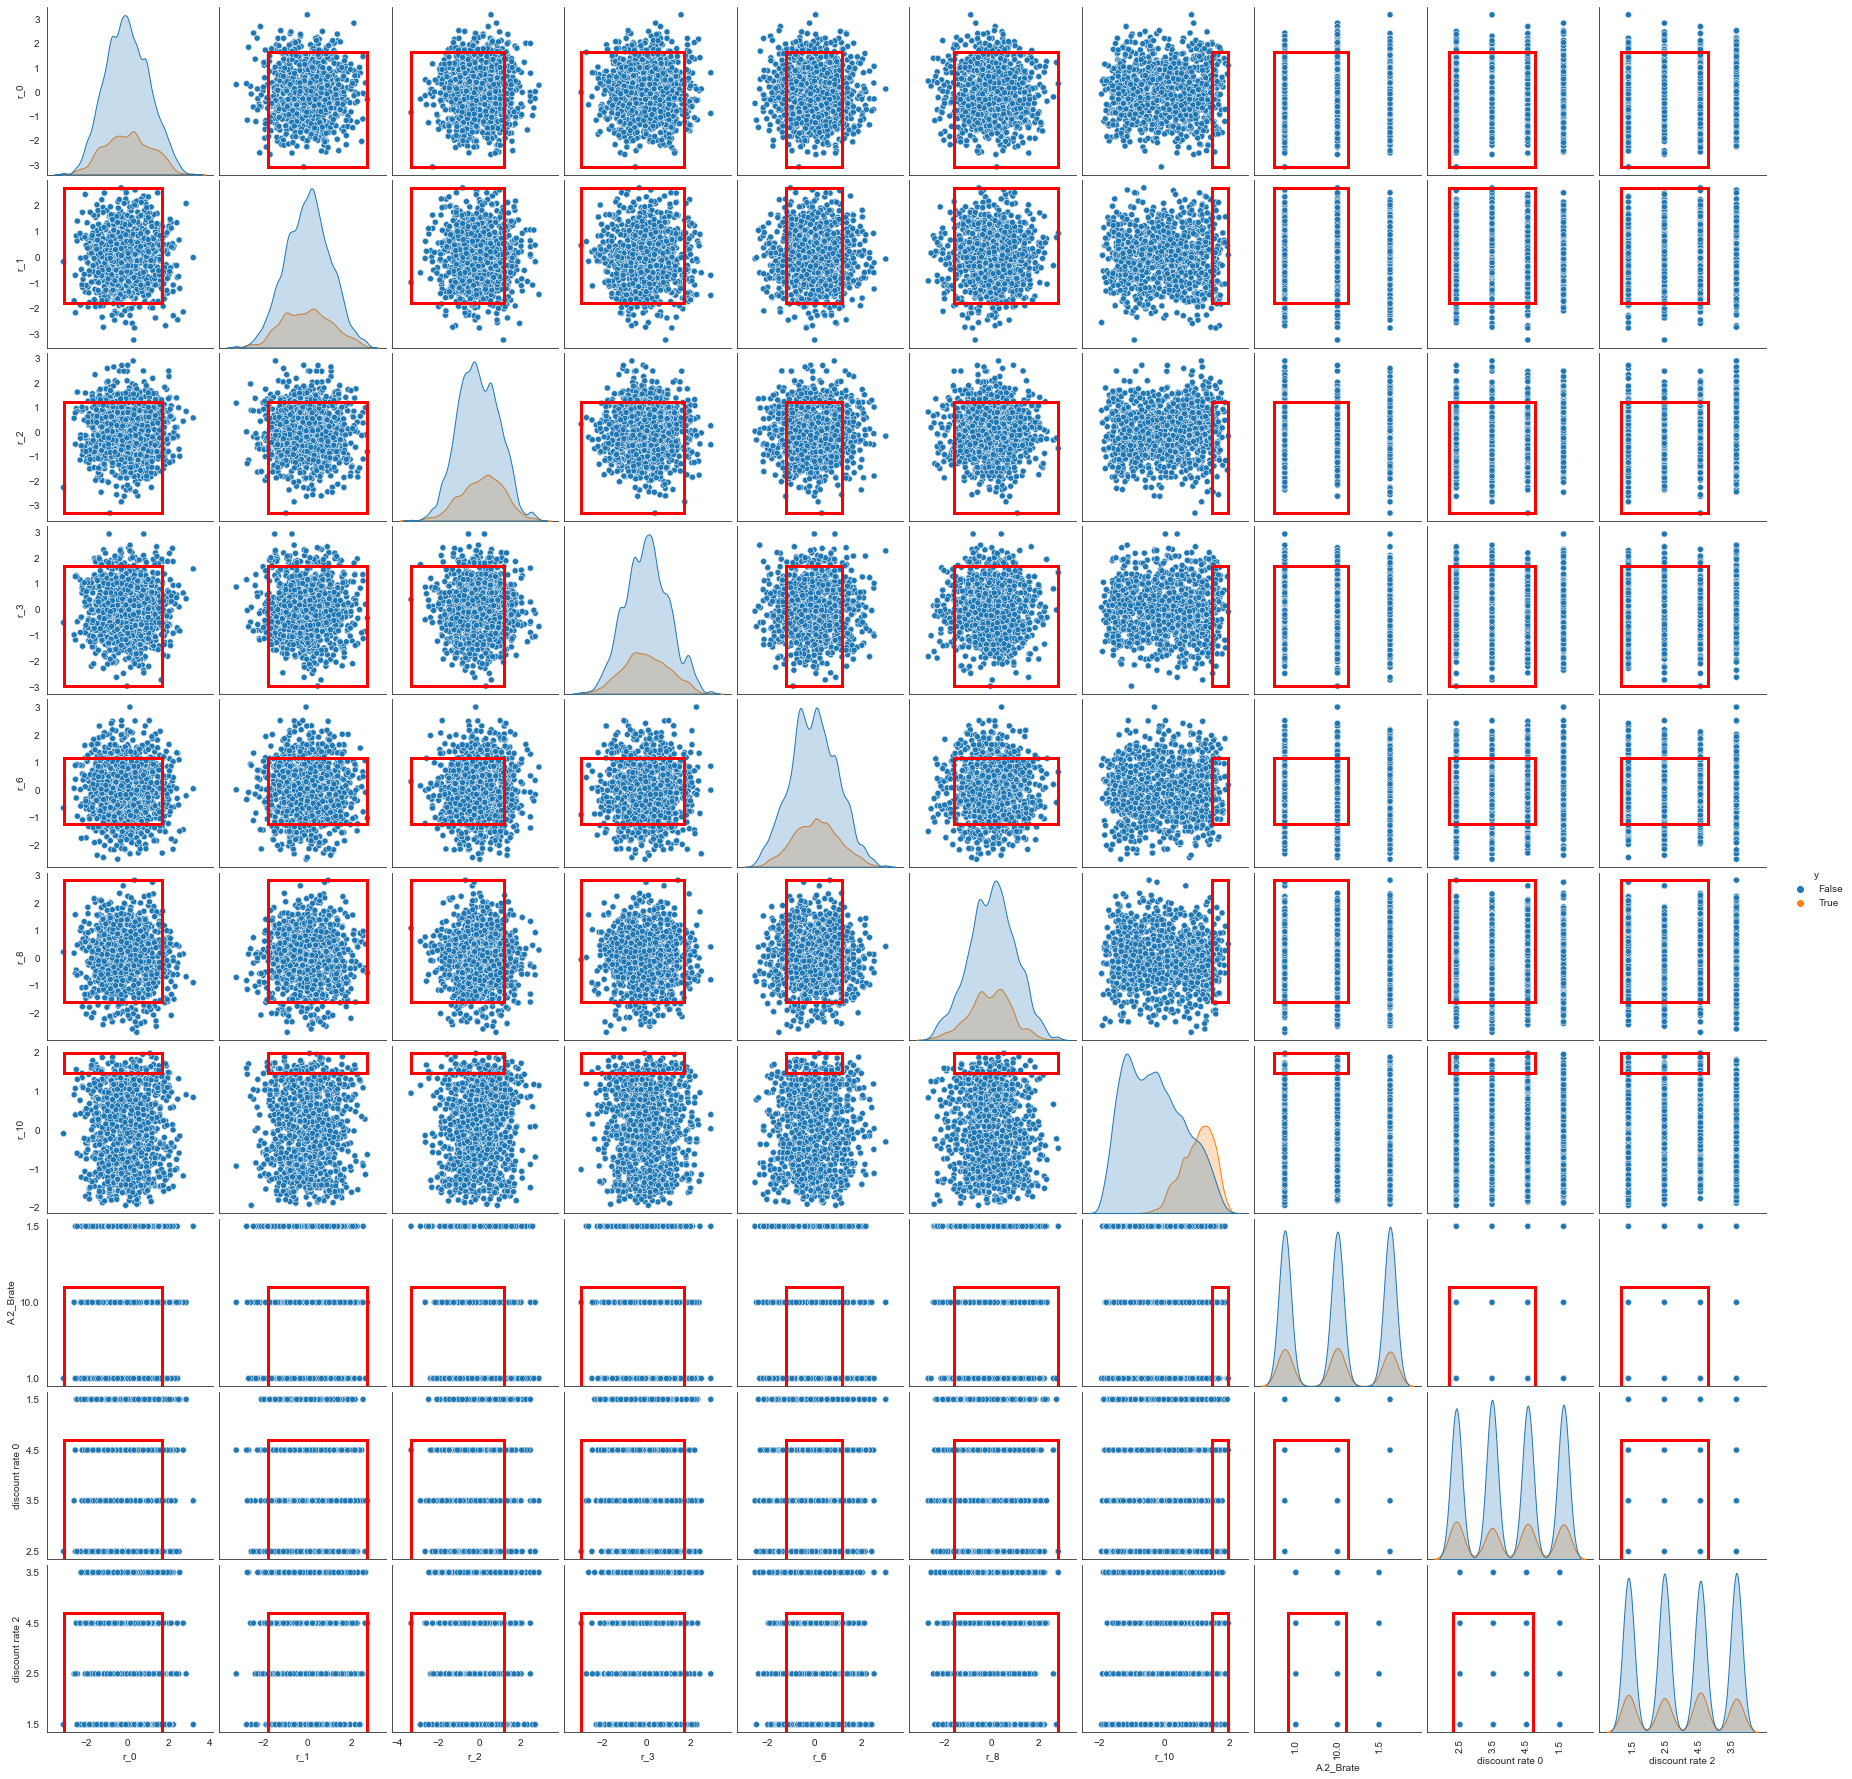

In [28]:
box.show_pairs_scatter()
plt.show()

In [29]:
box.inspect(14)

coverage    0.602299
density     0.604848
id                14
mass           0.226
mean        0.604848
res_dim            1
Name: 14, dtype: object

       box 14                       
          min       max    qp values
r_10  0.94064  1.972097  [0.0, -1.0]



In [30]:
box.select(14)

In [31]:
scen_box = experiments.iloc[box.yi]
outcomes_box = {k:v[box.yi] for k,v in outcomes.items()}

In [32]:
scen_box.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                     float64
0_RfR 1                     float64
0_RfR 2                     float64
1_RfR 0                     float64
1_RfR 1                     float64
1_RfR 2                     float64
2_RfR 0                     float64
2_RfR 1                     float64
2_RfR 2                     

In [38]:
for i in scen_box.select_dtypes(include=pd.CategoricalDtype).columns:
    scen_box[i] = scen_box[i].astype(str)

<ipython-input-38-62d0b6b66d55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scen_box[i] = scen_box[i].astype(str)


In [39]:
scen_box.dtypes

A.0_ID flood wave shape    float64
A.1_Bmax                   float64
A.1_Brate                   object
A.1_pfail                  float64
A.2_Bmax                   float64
A.2_Brate                   object
A.2_pfail                  float64
A.3_Bmax                   float64
A.3_Brate                   object
A.3_pfail                  float64
A.4_Bmax                   float64
A.4_Brate                   object
A.4_pfail                  float64
A.5_Bmax                   float64
A.5_Brate                   object
A.5_pfail                  float64
discount rate 0             object
discount rate 1             object
discount rate 2             object
0_RfR 0                    float64
0_RfR 1                    float64
0_RfR 2                    float64
1_RfR 0                    float64
1_RfR 1                    float64
1_RfR 2                    float64
2_RfR 0                    float64
2_RfR 1                    float64
2_RfR 2                    float64
3_RfR 0             

In [41]:
save_results((scen_box, outcomes_box), 'mordm_14.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\mordm_14.tar.gz
